In [1]:
import numpy as np
np.set_printoptions(suppress=True)
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

from utils import *

In [2]:
def devide_bgr(img):
    m,n = img.shape
    n_rows = int(m//3)

    img_b = img[:n_rows]
    img_g = img[n_rows:n_rows*2]
    img_r = img[n_rows*2:n_rows*3]
    return img_b, img_g, img_r

def align_bgr(img_b, img_g, img_r, align_vec_g=(0,0), align_vec_r=(0, 0)):
    m, n = img_b.shape
    img_g_shift = shift_image(img_g, align_vec_g[0],  align_vec_g[1])
    img_r_shift = shift_image(img_r, align_vec_r[0],  align_vec_r[1])
    img_color = np.zeros((m,n,3))
    img_color[:,:,0] = img_r_shift
    img_color[:,:,1] = img_g_shift
    img_color[:,:,2] = img_b
    return img_color

def SSD(img_1, img_2, boundary_cropping=False):
    if img_1.shape != img_2.shape:
        raise Exception('Different shape %s, %s'%(img_1.shape, img_2.shape))
    diff = img_1 - img_2
    if boundary_cropping:
        m, n = diff.shape
        cy = int(m//10)
        cx = int(n//10)
        diff[:cy, :cx] = 0
        diff[:cy, -cx:]= 0
        diff[-cy:, :cx] = 0
        diff[-cy:, -cx:] = 0
        
    return np.sum(diff*diff)

In [3]:
def get_similar(r, g, b, rad): 
    bg_similar = similarity(b, g, rad)
    br_similar = similarity(b, r, rad)
    return (bg_similar, br_similar)

def similarity(img_b, img, rad):
    mat = np.zeros((rad*2, rad*2))
    for i in range(-rad, rad):
        for j in range(-rad, rad):
                img_new = np.roll(img, i, axis=0)
                img_new = np.roll(img_new, j, axis=1)
                ssd_val = ssd(img_b, img_new)
                mat[i+rad, j+rad] = ssd_val

    lowest = mat.argmin() 
    row_shift = (lowest // (rad*2)) - rad ##check this part **
    col_shift = (lowest % (rad*2)) - rad ##check this part **
    return (row_shift, col_shift)

def ssd(img_1, img_2):
    ssd = np.sum((img_1 - img_2) **2)
    return ssd

In [4]:
def pyramid_colorize(img):
    print("img shape", img.shape)
    # compute the height of each channel of image (1/3 of total height)
    height = int(np.floor(img.shape[0] / 3.0))
    print('height: ', height)
    b, g, r = devide_bgr(img)

    b = crop(b)
    g = crop(g)
    r = crop(r)
    
    original_b, original_r, original_g = b, r, g

    # Applying sobel filter
    print('applying sobel filter...', end=' ')
    sobel_x, sobel_y = get_sobel_filter()
    b = convolution_2D(b, sobel_x)
    b = convolution_2D(b, sobel_y)
    g = convolution_2D(g, sobel_x)
    g = convolution_2D(g, sobel_y)
    r = convolution_2D(r, sobel_x)
    r = convolution_2D(r, sobel_y)
    print("finish sobel")
    
    # pyramid implementation 
    factor_f = 2
    factor_rad = 2
    f = 8
    window_size = int((height // f) // 5) 
    total_row_shift_g, total_col_shift_g, total_row_shift_r, total_col_shift_r = 0, 0, 0, 0

    while (f>=1): 
        #downscale first
        print("Scaling Factor: (1/%d), Window size: (%d)"%(f, window_size))
        m, n = b.shape
        b_sub = subsampling(b, size=(int(m/f), int(n/f)))
        r_sub = subsampling(r, size=(int(m/f), int(n/f)))
        g_sub = subsampling(g, size=(int(m/f), int(n/f)))

        # print('image size: ', mini_b.shape)

        #compute similarity
        similar_result = get_similar(r_sub, g_sub, b_sub, window_size)
        row_shift_g, col_shift_g = similar_result[0] #x, y shift for g
        row_shift_r, col_shift_r = similar_result[1] #x, y shift for r 

        #rolling
        total_row_shift_g += (row_shift_g * f) 
        total_col_shift_g += (col_shift_g * f) 
        total_row_shift_r += (row_shift_r * f) 
        total_col_shift_r += (col_shift_r * f) 

        g = shift_image(g, col_shift_g * f, row_shift_g * f)
        r = shift_image(r, col_shift_r * f, row_shift_r * f)

        #updating factors
        f = f // factor_f
        window_size = window_size // 2

        # create a color image
        print('Green Align Vector: (%d, %d)'%(total_row_shift_g,  total_col_shift_g))
        print('Red Align Vector:   (%d, %d)'%(total_row_shift_r,  total_col_shift_r))
        original_g = shift_image(original_g, total_col_shift_g, total_row_shift_g)
        original_r = shift_image(original_r, total_col_shift_r, total_row_shift_r)

        img_out = np.dstack([original_r, original_g, original_b])

        # display the image
        plt.figure(figsize=(20,20))
        plt.imshow(img_out)
        plt.show()
        
        return img_out

img shape (9627, 3702)
height:  3209
applying sobel filter... finish sobel
Scaling Factor: (1/8), Window size: (80)
Green Align Vector: (48, 24)
Red Align Vector:   (104, 40)


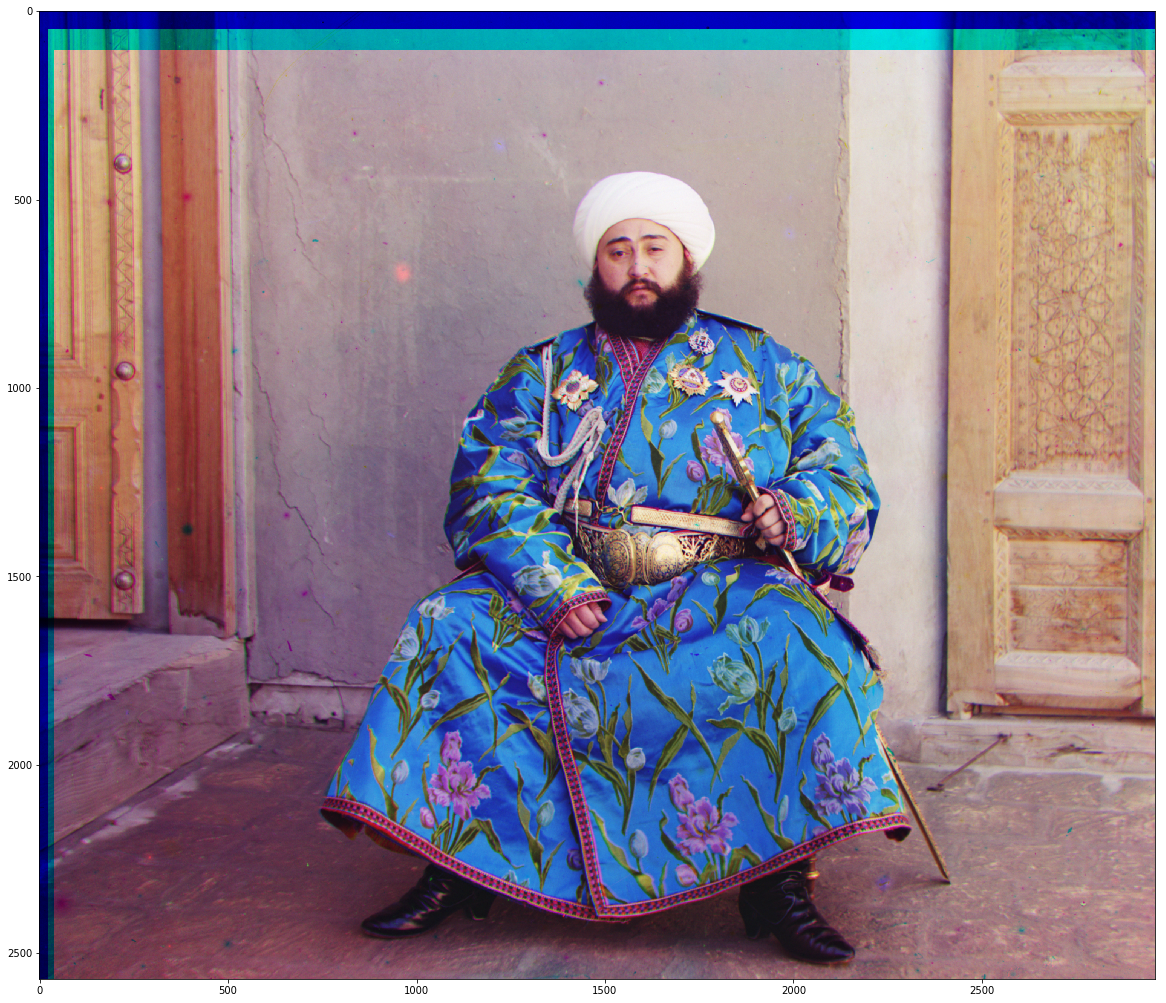

results/emir.tif.png
img shape (9732, 3741)
height:  3244
applying sobel filter... finish sobel
Scaling Factor: (1/8), Window size: (81)
Green Align Vector: (40, 16)
Red Align Vector:   (88, 24)


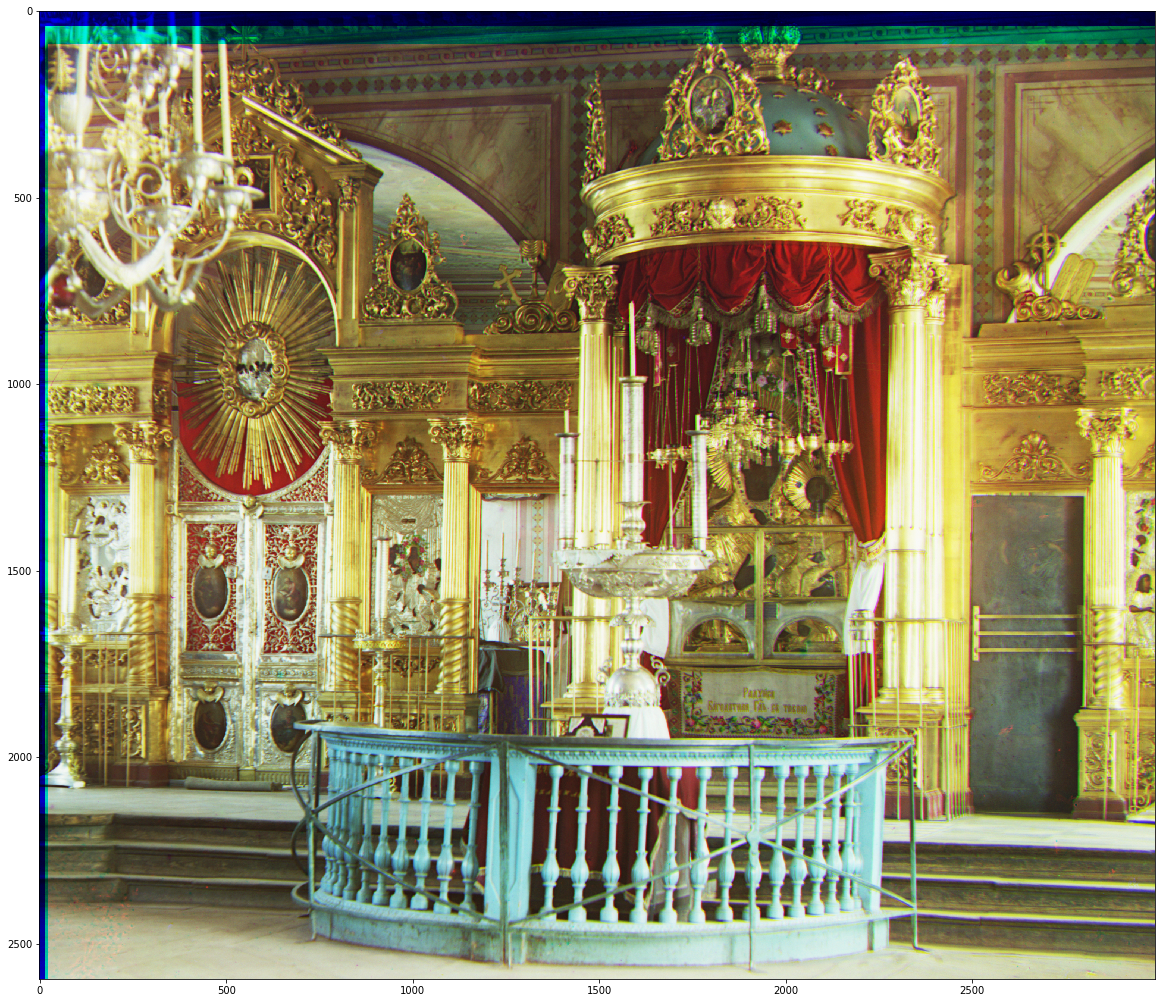

results/icon.tif.png
img shape (9637, 3761)
height:  3212
applying sobel filter... finish sobel
Scaling Factor: (1/8), Window size: (80)
Green Align Vector: (56, 8)
Red Align Vector:   (0, 0)


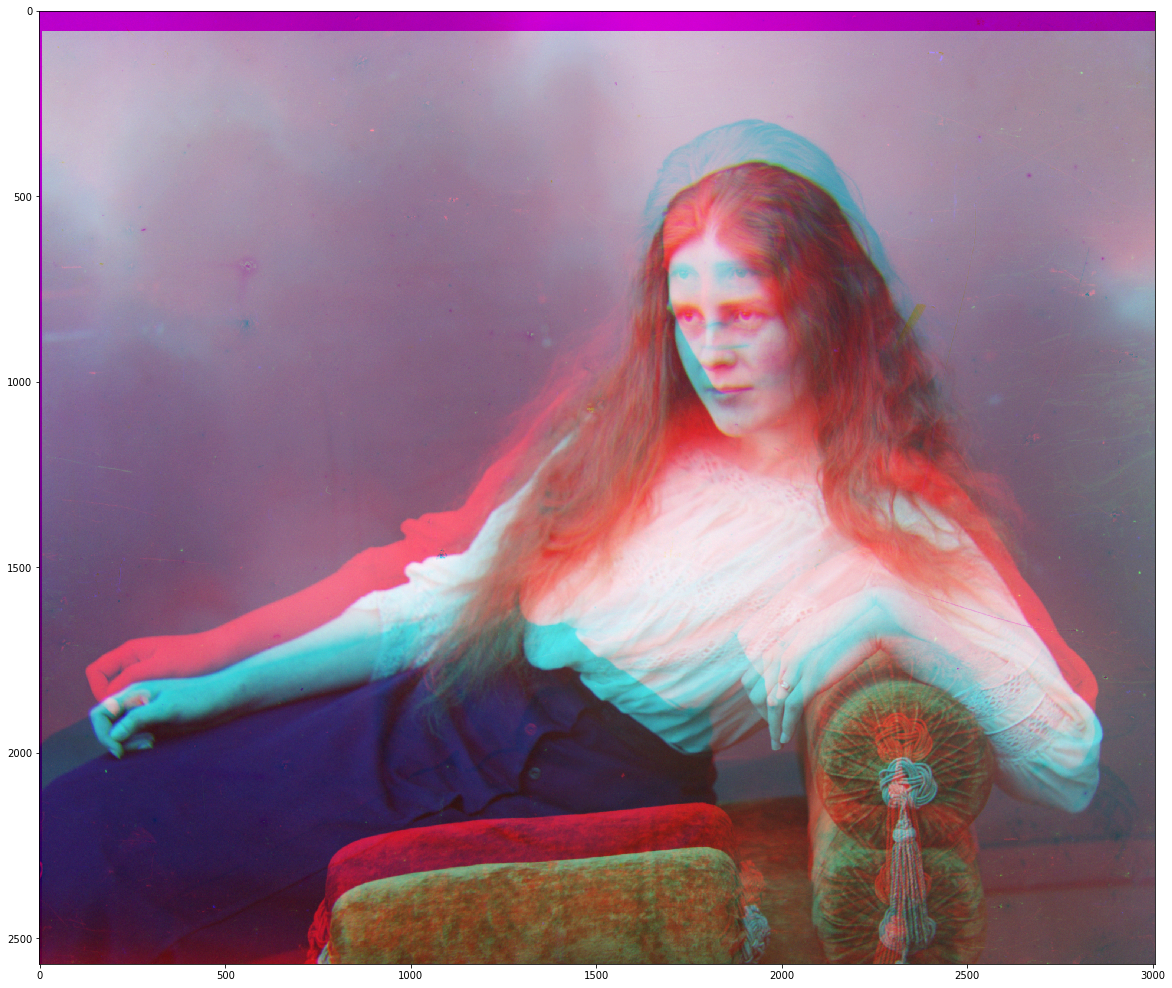

results/lady.tif.png
img shape (9724, 3770)
height:  3241
applying sobel filter... 

In [ ]:
import glob
img_names = glob.glob("datas/*")
for img_name in img_names:
    img = cv2.imread(img_name, -1)
    m, n = img.shape
    if m > 9000:
        img = img / img.max()
        img_color = pyramid_colorize(img)
        save_name  = 'results/' + img_name.split('datas')[1][1:].split('.')[0] + ".png"
        print(save_name)
        img_color = (img_color*255.0*255.0).astype(np.uint16)
        img_bgr = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
        cv2.imwrite(save_name, img_bgr)

# Old codes

In [ ]:
img = cv2.imread("datas/lady.tif", -1)
img = img / img.max()
m, n = img.shape
print(img.shape)
plt.imshow(img, cmap='gray') # BGR
plt.show()

In [14]:
print("img shape", img.shape)
# compute the height of each channel of image (1/3 of total height)
height = int(np.floor(img.shape[0] / 3.0))
print('height: ', height)
b, g, r = devide_bgr(img)

b = crop(b)
g = crop(g)
r = crop(r)

original_b, original_r, original_g = b, r, g

# Applying sobel filter
print('applying sobel filter...', end=' ')
sobel_x, sobel_y = get_sobel_filter()
b = convolution_2D(b, sobel_x)
b = convolution_2D(b, sobel_y)
g = convolution_2D(g, sobel_x)
g = convolution_2D(g, sobel_y)
r = convolution_2D(r, sobel_x)
r = convolution_2D(r, sobel_y)
print("finish sobel")

img shape (1800, 600)
height:  600
applying sobel filter... finish sobel


Scaling Factor: (1/8), Window size: (15)
Scaling Factor: (1/4), Window size: (7)
Scaling Factor: (1/2), Window size: (3)
Scaling Factor: (1/1), Window size: (1)
Green Align Vector: (10, 1)
Red Align Vector:   (22, 2)


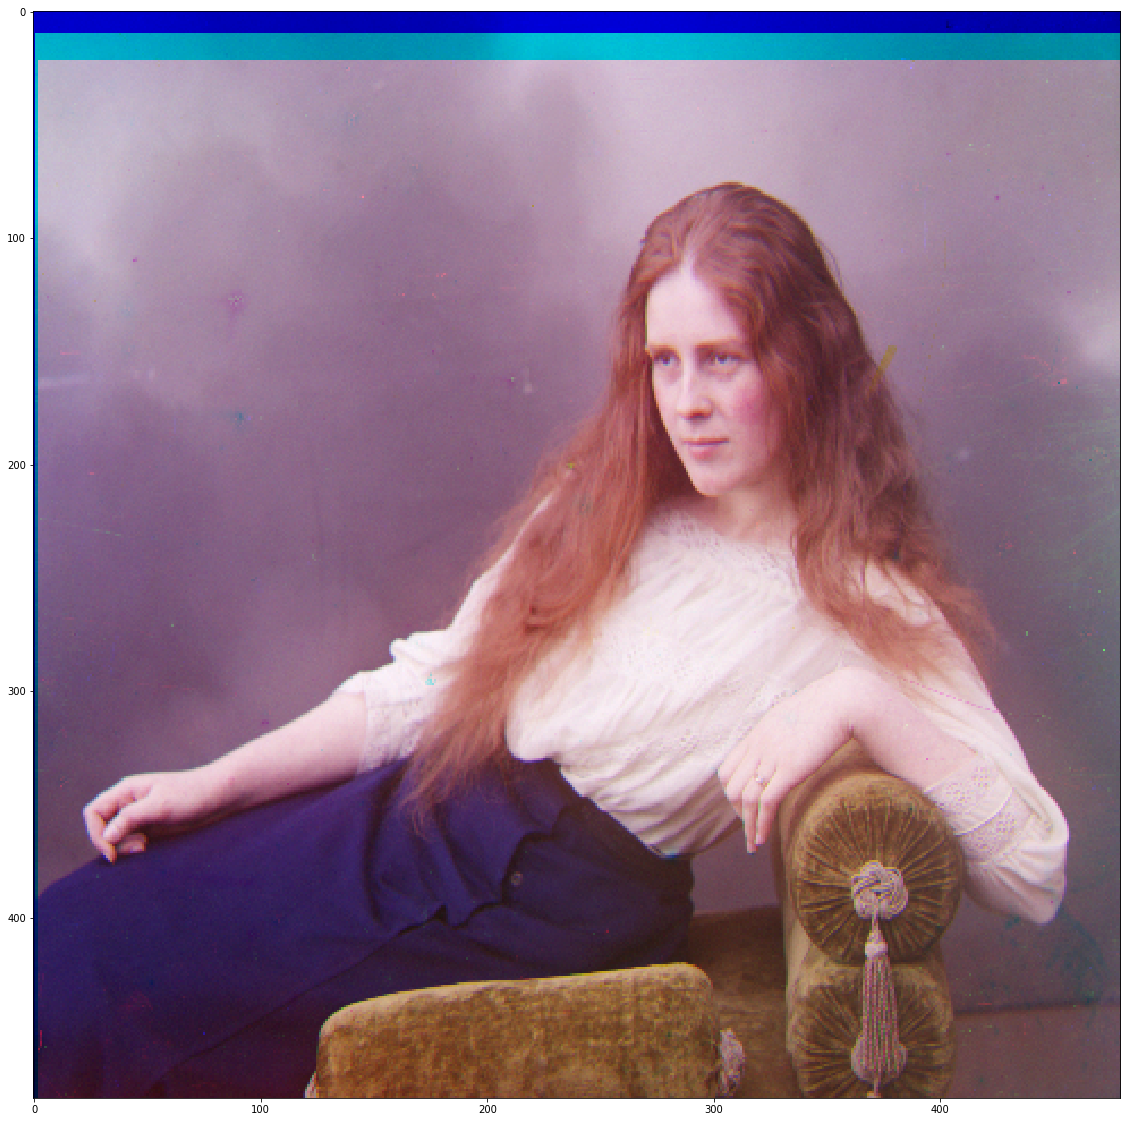

In [15]:
#pyramid implementation 
factor_f = 2
factor_rad = 2
f = 8
window_size = int((height // f) // 5) 
total_row_shift_g, total_col_shift_g, total_row_shift_r, total_col_shift_r = 0, 0, 0, 0

while (f>=1): 
    #downscale first
    print("Scaling Factor: (1/%d), Window size: (%d)"%(f, window_size))
    m, n = b.shape
    b_sub = subsampling(b, size=(int(m/f), int(n/f)))
    r_sub = subsampling(r, size=(int(m/f), int(n/f)))
    g_sub = subsampling(g, size=(int(m/f), int(n/f)))

    # print('image size: ', mini_b.shape)

    #compute similarity
    similar_result = get_similar(r_sub, g_sub, b_sub, window_size)
    row_shift_g, col_shift_g = similar_result[0] #x, y shift for g
    row_shift_r, col_shift_r = similar_result[1] #x, y shift for r 

    #rolling
    total_row_shift_g += (row_shift_g * f) 
    total_col_shift_g += (col_shift_g * f) 
    total_row_shift_r += (row_shift_r * f) 
    total_col_shift_r += (col_shift_r * f) 
    
    g = shift_image(g, col_shift_g * f, row_shift_g * f)
    r = shift_image(r, col_shift_r * f, row_shift_r * f)
    
    #updating factors
    f = f // factor_f
    window_size = window_size // 2


# create a color image
print('Green Align Vector: (%d, %d)'%(total_row_shift_g,  total_col_shift_g))
print('Red Align Vector:   (%d, %d)'%(total_row_shift_r,  total_col_shift_r))
original_g = shift_image(original_g, total_col_shift_g, total_row_shift_g)
original_r = shift_image(original_r, total_col_shift_r, total_row_shift_r)

img_out = np.dstack([original_r, original_g, original_b])

# display the image
plt.figure(figsize=(20,20))
plt.imshow(img_out)
plt.show()